# Introduction to matchms

`matchms` is an open-source Python library to handle, process, and compare MS/MS spectra. It is particularly geared towards large-scale similarity computations. In addition, matchms is intended to serve as a hub for developing new computational tools on top of it.

Some tools which are build on top of matchms:

+ [`Spec2Vec`](https://github.com/iomega/spec2vec) an alternative machine-learning spectral similarity score that can simply be installed by `pip install spec2vec` and be imported as `from spec2vec import Spec2Vec` following the same API as the scores in `matchms.similarity`.

+ [`MS2DeepScore`](https://github.com/matchms/ms2deepscore) a supervised, deep-learning based spectral similarity score that can simply be installed by `pip install ms2deepscore` and be imported as `from ms2deepscore import MS2DeepScore` following the same API as the scores in `matchms.similarity`.

+ [`MS2Query`](https://github.com/iomega/ms2query) Reliable and fast MS/MS spectral-based analogue search, running on top of matchms.

+ [`memo`](https://github.com/mandelbrot-project/memo) a method allowing a Retention Time (RT) agnostic alignment of metabolomics samples using the fragmentation spectra (MS2) of their constituents.

The source code of `matchms` is on GitHub --> https://github.com/matchms/matchms
This is also where you can interact with the developers of the tool (e.g., report problems, suggest new features, or: contribute yourself!).

In [ ]:
# matchms is preinstalled in this Colab environment, but if you want to run this notebook on your own computer, you can install it via pip:
#!pip install matchms

# Import libraries

In [1]:
import os
from matplotlib import pyplot as plt

from matchms import calculate_scores
from matchms.importing import load_from_mgf

## Import data
`matchms` can import and export MS/MS spectra from/to a few common formats such as .mgf, .msp, .mzxml, .json. Here we will simply import the example data as it came straight from MzMine.

The following code assumes that you copied the sumerschool2023_matchms folder to your own Google Drive. Please adapt the path accordingly if you have the files elsewhere.

In [ ]:
# Use this to mount your own google drive
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
# Specify data (and model) locations
#path_root = "./drive/MyDrive/matchms/summerschool2023_matchms"
#file = os.path.join(path_root, "data_mzmine", "example_iimn_gnps.mgf")
path_root = os.path.join("..")
file = os.path.join(path_root, "data", "mzmine_output", "Example", "example_sirius.mgf")

# Import spectra
spectra = list(load_from_mgf(file))

## What do we get from this?
Let's have a look at what the spectra now look like within matchms.

In [3]:
len(spectra)

73857

In [4]:
type(spectra)

list

In [5]:
spectra[1]

Spectrum(precursor m/z=503.14, 1 fragments between 341.1 and 341.1)

## matchms `Spectrum` objects
In `matchms` each MS/MS spectrum is handled as a `Spectrum` object.

- contains the MS/MS fragments --> `spectrum.peaks`  
For instance for the 10th spectrum in our list this would be `spectra[9].peaks`.   
The fragments are divided into m/z positions --> `spectrum.peaks.mz`  
and intensities --> `spectrum.peaks.intensities`
- contains the metadata --> `spectrum.metadata`

It also comes with basic functions (methods) to inspect or edit parts of the spectrum.
- basic plotting --> `spectrum.plot()`
- read metadata fields --> `spectrum.get("charge")`
- set metadata fields --> `spectrum.get("special_comments", "Nice!")`

### Mini-Exercise:
- How many fragments/peaks has the first spectrum in our list?
- What is the highest fragement m/z?
- Use the `.set()` method to add a "note_to_supervisor" field to the metadata and write into this field whatever you like (your superviser is likely to never read it...)
- Check if you indeed added the note by using the `.get()` method.

### Plot a histogram of the number of fragments per spectrum

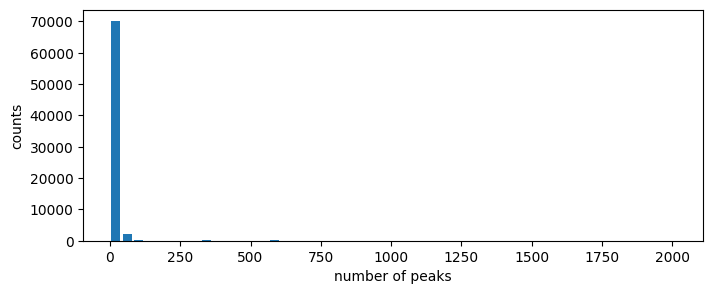

In [6]:
number_of_peaks = [len(s.peaks) for s in spectra]

fig, ax = plt.subplots(figsize=(8, 3))
ax.hist(number_of_peaks, bins=50, rwidth=0.8)
ax.set_ylabel("counts")
ax.set_xlabel("number of peaks")
plt.show()

## Process spectra

`matchms` comes with many filtering functions (in `matchms.filtering`). Even better: If you want something very specific or novel, you can also build your own filters. And even better yet: you could become a co-developer of matchms and add a filter you miss to the library!

In general, there are two types of filters: Filters with focus on the **metadata** and for **fragments**. Metadata filters can be used to correct, add to or edit specific metadata fields, and to harmonize them. In addition there are filters for the **fragments**, for instance to remove small peaks, normalize peak intensities etc.

From matchms 0.22 on, the central element to apply filters is the `SpectrumProcessor`.
Some filters allow advanced configuration by passing a dict with options and corresponding values.

### Mini-Exercise:
Here, we want to apply:
- A few default filters to harmonize metadata
- Normalize peak intensities (to max=1.0)
- Remove all peaks outside 10.0 to 1000.0 Da m/z window
- Remove spectra with < 4 remaining peaks

The last two teps are potentially important for tools like `Spec2Vec` or `MS2DeepScore` which make predictions solely based on the MS2 peaks.

In [ ]:
from matchms import SpectrumProcessor
from matchms.filtering.default_pipelines import BASIC_FILTERS

min_number_peaks = # add your code here

# Define filter pipeline
processor = SpectrumProcessor(BASIC_FILTERS)
processor.parse_and_add_filter("normalize_intensities")
processor.parse_and_add_filter(("select_by_mz", {"mz_from": # add your code here, "mz_to": # add your code here}))
processor.parse_and_add_filter(("require_minimum_number_of_peaks", {"n_required": min_number_peaks}))

# Apply filter pipeline
# process_spectrum will return a tuple of spectra_cleaned and a processing_report
spectra_cleaned, _ = processor.process_spectra(spectra)
print(f"Number of remaining spectra: {len(spectra_cleaned)}")

In [ ]:
import numpy as np

bins = np.arange(0, 40, 1)

# Create 2 sub-plots
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 7))
ax1.hist([len(s.peaks) for s in spectra], bins=bins, rwidth=0.8)
ax1.set_title("before filtering")
ax1.set_ylabel("counts")
ax2.hist([len(s.peaks) for s in spectra_cleaned], bins=bins, rwidth=0.8)
ax2.set_title("after filtering")
ax2.set_ylabel("counts")
ax2.set_xlabel("number of peaks in spectrum")
plt.show()

In [ ]:
spectra_cleaned[0].metadata

In [ ]:
# Write a small script to add the ionmode

## Basic plotting (only for quick inspection)

In [ ]:
spectra_cleaned[0].plot()

In [ ]:
spectra_cleaned[0].plot_against(spectra_cleaned[151])

In [ ]:
from matchms.plotting import plot_spectra_array

plot_spectra_array(spectra_cleaned[:9], 3)
plt.show()

## Spectrum similarity computation

Matchms comes with several spectrm similarity scores such as:
- Cosine (`CosineGreedy`)
- Modified Cosine (`ModifiedCosine`)
- Molecular fingerprint based scoring (`FingerprintSimilarity`)
- Precursor m/z matching (`PrecursorMzMatch`)

A core feature, however, is that you can also build (program) your own similarity measures or import other compatible ones (for instance: `Spec2Vec` or `MS2DeepScore`).

In [ ]:
from matchms.similarity import PrecursorMzMatch, CosineGreedy

similarity_measure = PrecursorMzMatch(tolerance= # set on your own,
                                      tolerance_type="Dalton")  # alternative would be "ppm"
scores = calculate_scores(spectra_cleaned, spectra_cleaned, similarity_measure)
scores

In [ ]:
# what is this number for?
3802 ** 2

In [ ]:
# Let's compute the Cosine score for all pairs which have a precursor match

### Inspect results

In [ ]:
results = scores.scores_by_query(spectra_cleaned[2], "CosineGreedy_score", sort=True)
results

### Remove scores below threshold

In [ ]:
scores.filter_by_range(name="CosineGreedy_score",
                       low= 0.7)

### Inspect the results again

In [ ]:
results = scores.scores_by_query(spectra_cleaned[# pick your number],
                                 'CosineGreedy_score', sort=True)
results

In [ ]:
spectra_cleaned[1].plot_against(results[2][0])

In [ ]:
results = scores.scores_by_query(spectra_cleaned[# pick your number], 'CosineGreedy_score', sort=True)
plot_spectra_array([x[0] for x in results[:8]])